In [76]:
import torch
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

The device is cuda


In [78]:
# 定义 内容/风格/输出 文件夹
content_dir = './content'
style_dir = './style'
output_dir = './output'

# 图片的名称
content_name = 'great_wall2'
style_name = 'fuchun'
output_name = f'{content_name}_' + f'{style_name}'

# 路径(默认格式jpg,可以自行修改png等)
content_path = f'./{content_dir}/' + f'{content_name}.jpg'
style_path = f'./{style_dir}/' + f'{style_name}.jpg'
output_path = f'./{output_dir}/' + f'{output_name}.jpg'

def load_image(image_path):
    try:
        image = Image.open(image_path)
        if image is None:
            raise ValueError(f'Can not load image, please check path:{image_path}')
    except Exception as e:
        raise ValueError(f"Can not read image:{e}")

    return image

content_image = load_image(content_path)
style_image = load_image(style_path)


In [79]:
# 对输入图形进行预处理
def preprocess(img):
    Preprocess = transforms.Compose([
        # transforms.Resize((256,300)), # 改变图形大小
        transforms.Resize((256, int(256*img.width/img.height))),
        transforms.ToTensor(),  # 调整为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 标准化
    ])

    return Preprocess(img).unsqueeze(0) # 便于批量处理,在dim0上扩展维度

content_image = preprocess(content_image).to(device)
style_image = preprocess(style_image).to(device)

# print(content_image)
# print(style_image)

In [80]:
class VGGFeatures(torch.nn.Module):
    def __init__(self):
        super(VGGFeatures,self).__init__()
        if torch.cuda.device_count() > 1:
            print(f"Let's use {torch.cuda.device_count()} GPUs!")
            model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
            model = torch.nn.DataParallel(model)
        else:
            model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
        # self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
        self.vgg = model
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.to(device)

    def forward(self, x):
        features = []
        for layer in self.vgg if isinstance(self.vgg, torch.nn.DataParallel) else self.vgg:
            x = layer(x)
            if isinstance(layer, torch.nn.ReLU):
                features.append(x)
        return features
        

In [81]:
# 提取特征
def get_features(image, model):
    layers = {
        0 :'conv1', 
        2 :'conv2',
        5 :'conv3',
        7 :'conv4', 
        10:'conv5',
        12:'conv6',
        14:'conv7',
        16:'conv8',
        19:'conv9'

    }
    features = {}
    x = image

    if isinstance(model.vgg, torch.nn.DataParallel):
        for index, layer in model.vgg.module._modules.items():
            x = layer(x)
            index = int(index)
            if index in layers.keys():
                features[layers[index]] = x
              
    else:
        for name, layer in model._modules.items():
            for i in range(len(layer)):
                x = layer[i](x)
                if i in layers.keys():
                    features[layers[i]] = x



    return features

# 计算内容损失
def content_loss(content_weight, content_features, target_features):
    return content_weight * torch.mean((target_features - content_features) ** 2)

# 计算风格损失
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [82]:
def style_loss(style_weight, style_grams, target_features):
    loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_loss = style_weight * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss
    return loss

Let's use 4 GPUs!
Step 0, Content Loss:0.0, Style Loss:742902238019584.0
Total loss:742902238019584.0, percentage:100.0%


Step 100, Content Loss:44903.0078125, Style Loss:455802632536064.0
Total loss:455802632536064.0, percentage:61.35432052612305%
Step 200, Content Loss:62982.234375, Style Loss:260513422376960.0
Total loss:260513422376960.0, percentage:35.066986083984375%
Step 300, Content Loss:73781.515625, Style Loss:155603007700992.0
Total loss:155603007700992.0, percentage:20.94528579711914%
Step 400, Content Loss:81023.9296875, Style Loss:103126451355648.0
Total loss:103126451355648.0, percentage:13.881564140319824%
Step 500, Content Loss:86061.6953125, Style Loss:75173118083072.0
Total loss:75173118083072.0, percentage:10.118844032287598%
Step 600, Content Loss:89923.203125, Style Loss:58759565017088.0
Total loss:58759565017088.0, percentage:7.909461498260498%
Step 700, Content Loss:93004.65625, Style Loss:48204531892224.0
Total loss:48204531892224.0, percentage:6.488677978515625%
Step 800, Content Loss:95463.625, Style Loss:40900491214848.0
Total loss:40900491214848.0, percentage:5.505500793457031

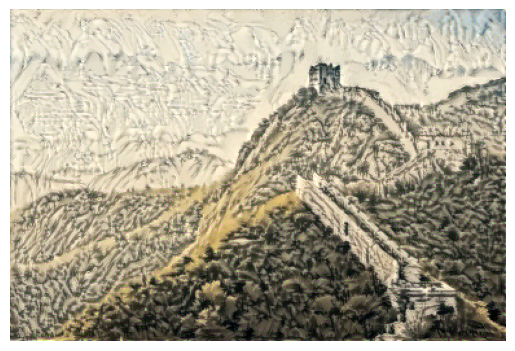

The Image has been Generated Successfully at ./output/great_wall2_fuchun.jpg


In [83]:
# 初始化模型和特征
vgg = VGGFeatures()
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 初始化目标图像
target_image = content_image.clone().requires_grad_(True)

# 优化器
optimizer = optim.Adam([target_image], lr=0.001)

# 训练循环
num_steps = 4000
content_weight = 1e4
style_weight = 1e5
init_loss = 0

for step in range(num_steps):
    target_features = get_features(target_image, vgg)
    c_loss = content_loss(content_weight, content_features['conv9'], target_features['conv9'])
    s_loss = style_loss(style_weight, style_grams, target_features)
    total_loss = c_loss + s_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step == 0:
        init_loss = total_loss
    if step % 100 == 0:
        print(f"Step {step}, Content Loss:{c_loss.item()}, Style Loss:{s_loss.item()}")
        print(f"Total loss:{total_loss}, percentage:{(100*total_loss/init_loss)}%")

# 显示结果
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(output_path,bbox_inches='tight', pad_inches=0)
    plt.show()

imshow(target_image, title='Styled Image')


print(f"The Image has been Generated Successfully at {output_dir}/{content_name}_{style_name}.jpg")